In [23]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [24]:
import plotly.express as px
import altair as alt

### Data Processing

In [25]:
world = gpd.read_file('world-countries.json')
df = pd.read_csv('population_prospects.csv')

c:\users\артем\appdata\local\programs\python\python38\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



In [26]:
countries_to_rep = {
    'The Bahamas': 'Bahamas',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Brunei Darussalam': 'Brunei',
    'Congo': 'Republic of the Congo',
    'Czechia': 'Czech Republic',
    'Falkland Islands (Malvinas)': 'Falkland Islands',
    'Papua New Guinea': 'Guinea Bissau',
    'Iran (Islamic Republic of)': 'Iran',
    "Dem. People's Republic of Korea": 'North Korea',
    'Republic of Korea': 'South Korea',
    'Russian Federation': 'Russia',
    'Somaliland': 'Somalia',
    'Republic of Serbia': 'Serbia',
    'Swaziland': 'Switzerland',
    'Syrian Arab Republic': 'Syria',
    'Timor-Leste': 'East Timor',
    'China, Taiwan Province of China': 'Taiwan',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Viet Nam': 'Vietnam',
    'Republic of Moldova': 'Moldova',
    'North Macedonia': 'Macedonia'
}

In [27]:
world.name = world.name.map(countries_to_rep).fillna(world.name)
df.country = df.country.map(countries_to_rep).fillna(df.country)

In [28]:
p2100 = df[(df.variant=='Medium variant') & (df.year==2100)].drop(columns=['variant', 'country_code', 'parent_code'])
p2000 = df[(df.variant=='Estimates') & (df.year==2000)].drop(columns=['variant', 'country_code', 'parent_code'])

In [29]:
countries = p2100.country.to_numpy()
is_increase = (p2100.population.to_numpy() > p2000.population.to_numpy())
is_increase = pd.Series(['More' if i else 'Less' for i in is_increase])
is_increase = is_increase.fillna('No data')
percent_increase = (p2100.population.to_numpy() - p2000.population.to_numpy()) / p2000.population.to_numpy()
p2100c = p2100.population.to_numpy()

In [30]:
df_1 = pd.DataFrame(np.array([countries, is_increase, percent_increase, p2100c]).T)
df_1.columns = ['countries', 'is_increase', 'percent_increase', 'p2100c']

In [31]:
def get_geometry(country, column):
    res = df_1[df_1.countries == country][column]
    # print(len(res))
    if len(res):
        return df_1[df_1.countries == country][column].iloc[0]
    else:
        return pd.NA

In [32]:
world['is_increase'] = [get_geometry(i, 'is_increase') for i in world['name'].values]
world['percent_increase'] = [get_geometry(i, 'percent_increase') for i in world['name'].values]
world['p2100c'] = [get_geometry(i, 'p2100c') for i in world['name'].values]

In [33]:
world_1 = world.dropna()

In [34]:
world_1['percent_increase'] = world_1.percent_increase.astype(float).values.copy()
world_1['percent_increase'] = [round(i, 2) for i in world_1['percent_increase']]
world_1['p2100c'] = world_1.p2100c.astype(int).values.copy()

C:\Users\328F~1\AppData\Local\Temp/ipykernel_14600/606644798.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\328F~1\AppData\Local\Temp/ipykernel_14600/606644798.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\328F~1\AppData\Local\Temp/ipykernel_14600/606644798.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

### 1. В яких країнах світу населення у 2100 році буде більшим, ніж було у 2000 році, а в яких меншим?

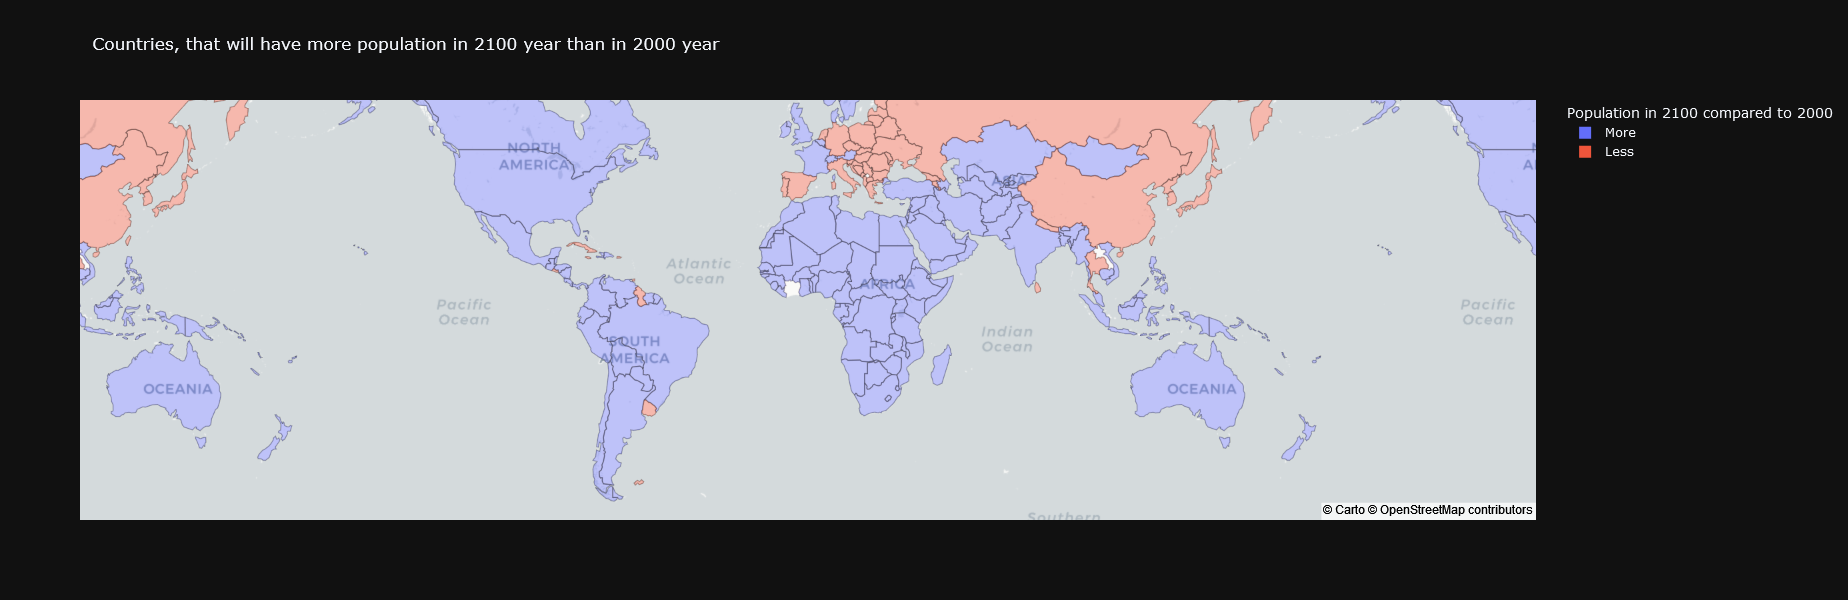

In [35]:
fig = px.choropleth_mapbox(world_1.dropna(),
                           title="Countries, that will have more population in 2100 year than in 2000 year",
                   geojson=world_1.dropna().geometry,
                   locations=world_1.dropna().index,
                   color="is_increase",
                   mapbox_style="carto-positron",
                   hover_name='name', hover_data=["p2100c", "is_increase"],
                   labels={'is_increase':'Population in 2100 compared to 2000',
                          True: 'Yes',
                          False: 'No',
                          'locations': 'Location index',
                          'p2100c': 'Population in 2100'},
                   template='plotly_dark',
                   opacity=0.4,
                   zoom=1,
                   height=600,
                   width=1400
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

### 2. На скільки відсотків збільшиться або зменшиться населення кожної країни у 2100 році у порівнянні з 2000 роком?

In [36]:
# Creating custom colormap
color_1 = [255, 0, 0]
color_2 = np.array([255, 248, 97])
color_3 = np.array([28, 163, 0])

color_delta = (color_2 - color_3)//24

color_e = []
for i in range(23):
    color = color_2 - color_delta*i
    color_e.append(color.tolist())
    
colorscale_custom = ['rgb' + str((i, j, k)) for i, j, k in [[255, 0, 0]] + color_e + [color_3.tolist()]]

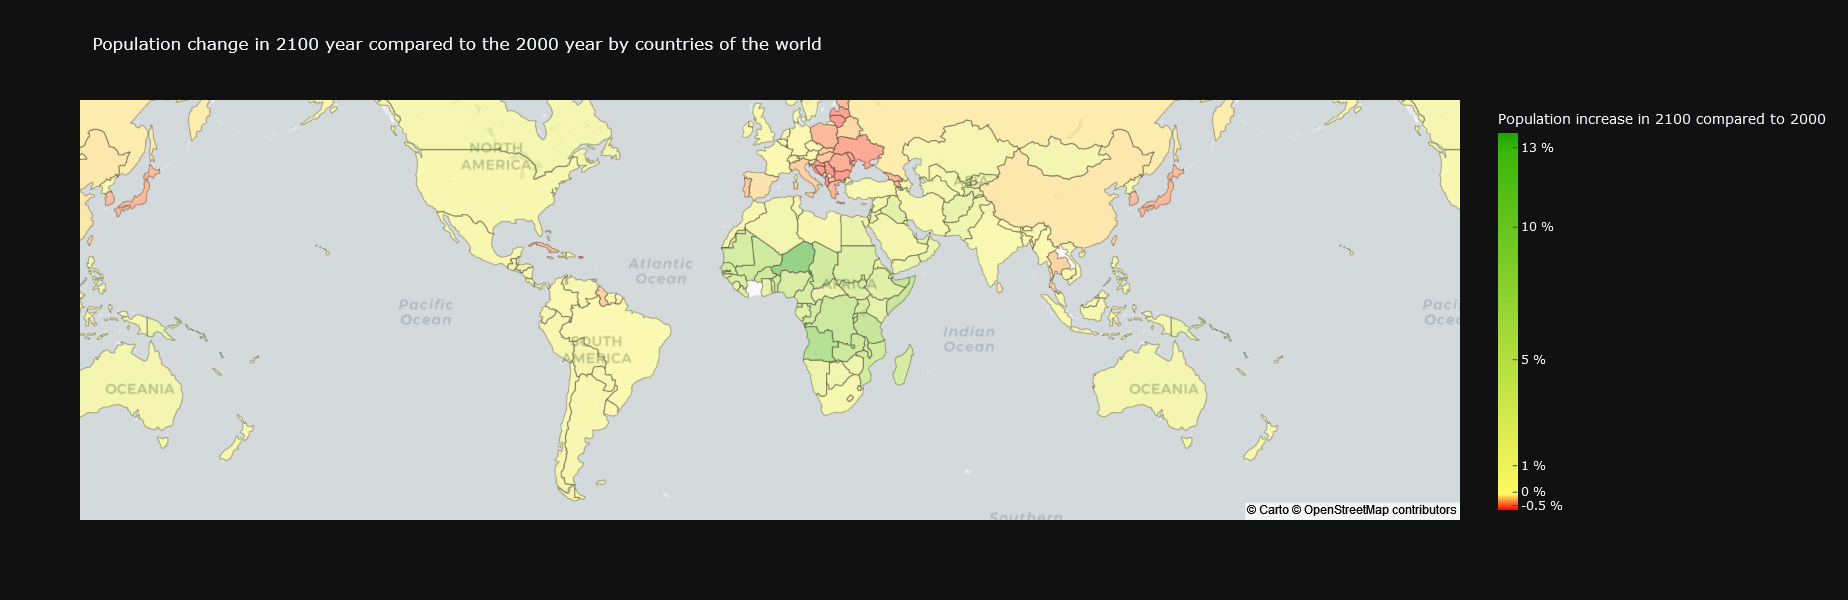

In [37]:
fig = px.choropleth_mapbox(world_1,
                           title="Population change in 2100 year compared to the 2000 year by countries of the world",
                   geojson=world_1.geometry,
                   locations=world_1.index,
                   color="percent_increase",
                   mapbox_style="carto-positron",
                   hover_name='name', hover_data=["p2100c", "percent_increase"],
                   labels={'is_increase':'Population in 2100 compared to 2000',
                          'percent_increase': 'Increase in percents',
                           'index': 'Index',
                           True: 'Yes',
                          False: 'No',
                          'locations': 'Location index',
                          'p2100c': 'Population in 2021'},
                   range_color=[world_1.percent_increase.min(), world_1.percent_increase.max()],
                   color_continuous_scale=colorscale_custom,
                   template='plotly_dark',
                   opacity=0.45,
                   zoom=1,
                   height=600,
                   width=1400
                   )
tickvals = [-0.5, 0, 1, 5, 10, 13]
fig.update_layout(coloraxis_colorbar=dict(
    title="Population increase in 2100 compared to 2000",
    thicknessmode="pixels", thickness=20,
    ticks="inside",
    ticksuffix=" %",
    tickvals=tickvals,
    ticktext=[str(i) + " %" for i in tickvals]
))

fig.show()

### 3. Яким буде населення країн світу у 2100 році?

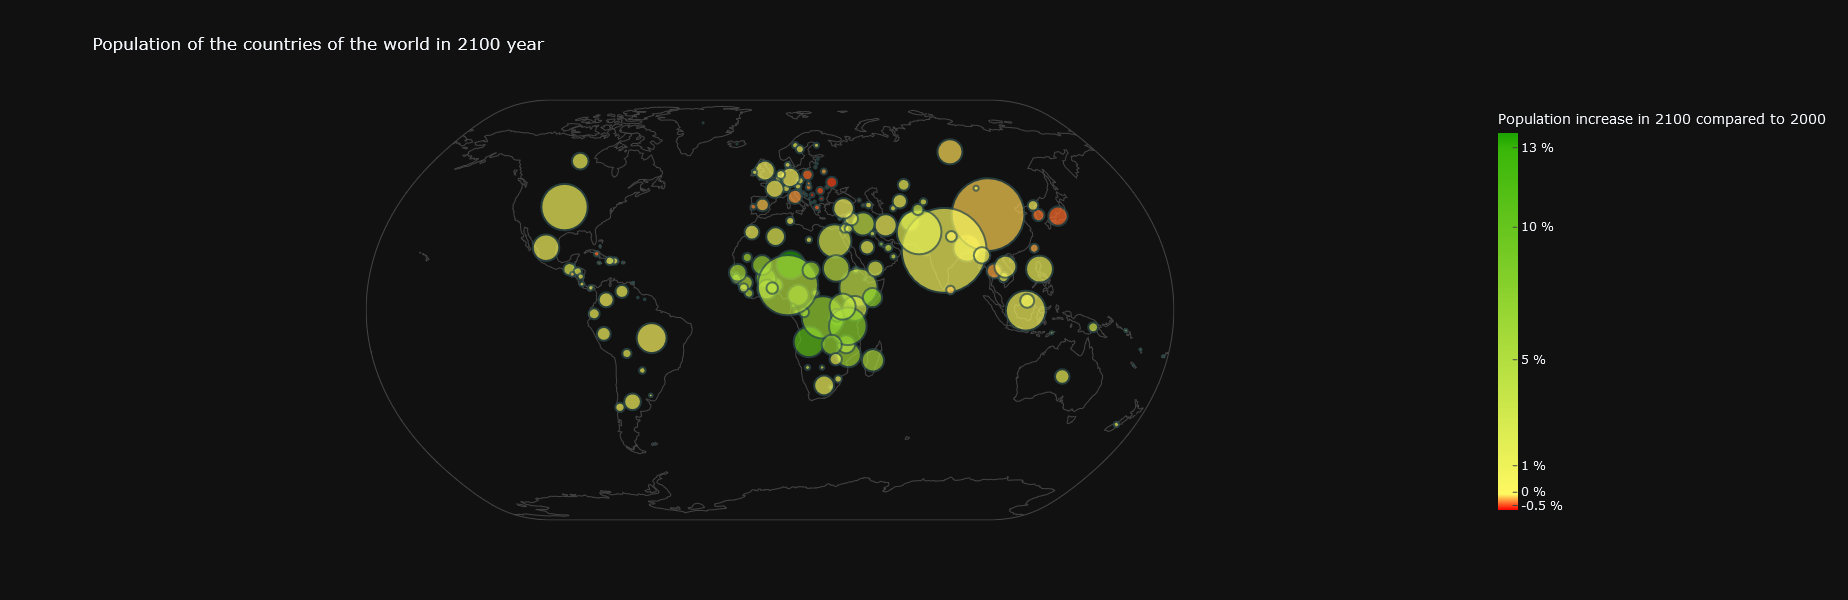

In [38]:
# Colors as population change
df = px.data.gapminder()
fig = px.scatter_geo(world_1, locations="id", color="percent_increase",
                     title="Population of the countries of the world in 2100 year",
                     hover_name="name", size="p2100c",
                     labels={'is_increase':'Population in 2100 compared to 2000',
                          'percent_increase': 'Increase in percents',
                             'id': 'Country',
                           'index': 'Index',
                           True: 'Yes',
                          False: 'No',
                          'locations': 'Location index',
                          'p2100c': 'Population in 2100, thousands of people'},
                     color_continuous_scale=colorscale_custom,
                     template='plotly_dark',
                     projection="natural earth", size_max=60,
                   height=600,
                   width=1400)

fig.update_layout(coloraxis_colorbar=dict(
    title="Population increase in 2100 compared to 2000",
    thicknessmode="pixels", thickness=20,
    ticks="inside",
    ticksuffix=" %",
    tickvals=tickvals,
    ticktext=[str(i) + " %" for i in tickvals]
))

fig.update_traces(marker=dict(
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

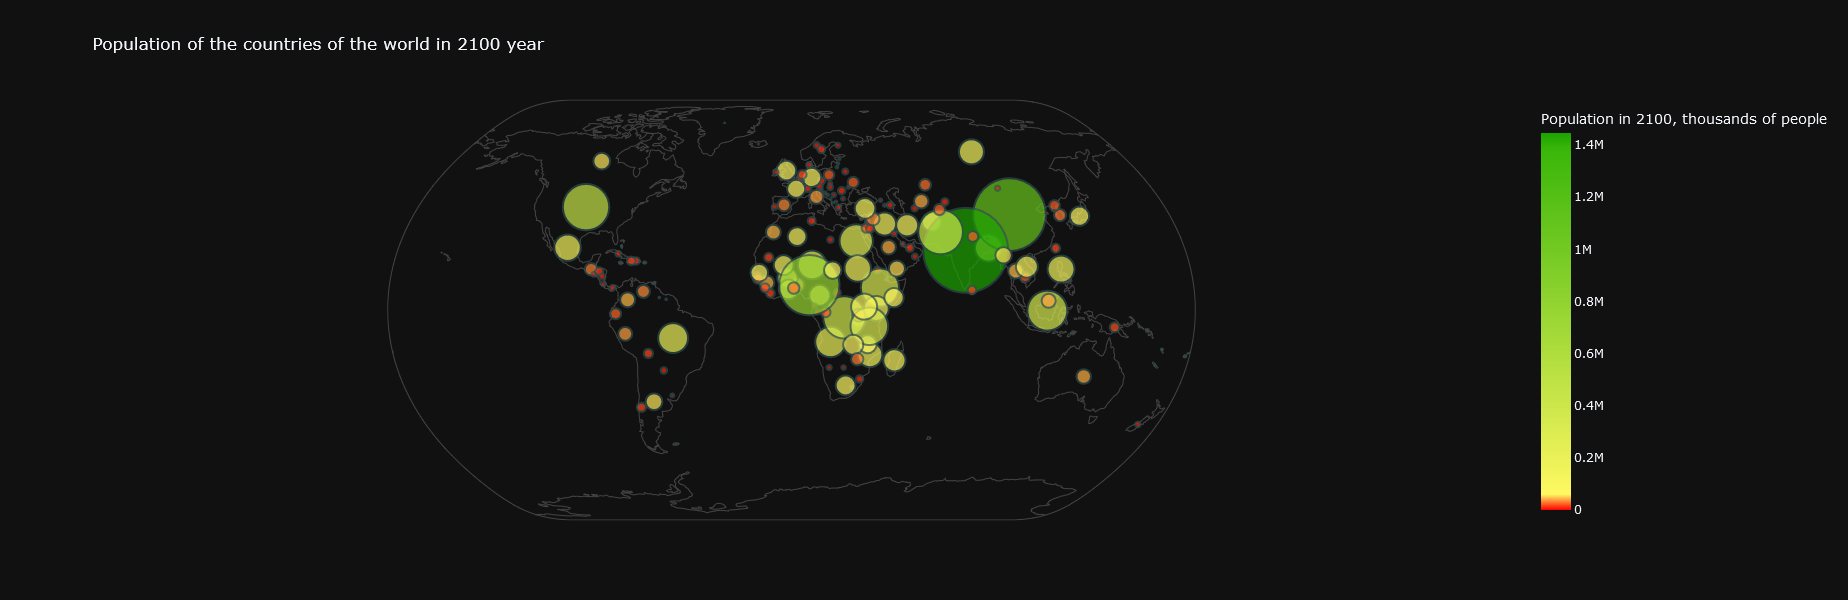

In [39]:
# Colors as population amount - Final

df = px.data.gapminder()
fig = px.scatter_geo(world_1, locations="id", color="p2100c",
                     title="Population of the countries of the world in 2100 year",
                     hover_name="name", size="p2100c",
                     color_continuous_scale=colorscale_custom,
                     labels={'is_increase':'Population in 2100 compared to 2000',
                          'percent_increase': 'Increase in percents',
                             'id': 'Country',
                           'index': 'Index',
                           True: 'Yes',
                          False: 'No',
                          'locations': 'Location index',
                          'p2100c': 'Population in 2100, thousands of people'},
                     template='plotly_dark',
                     projection="natural earth", size_max=60,
                   height=600,
                   width=1400)

fig.update_traces(marker=dict(
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [41]:
# !jupyter nbconvert --to html main.ipynb

[NbConvertApp] Converting notebook main.ipynb to html
[NbConvertApp] Writing 1403736 bytes to main.html
[NbConvertApp] Converting notebook main.ipynb to html
[NbConvertApp] Writing 5003346 bytes to main.html
